<a href="https://colab.research.google.com/github/ashishbhatta/Assignment-2/blob/main/Question_2/%20Fault_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Required Packages**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

from sklearn.model_selection import train_test_split #needed for spliting data into testing and training
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold

**Defining ML Classifier Models to be used**

In [4]:
models = {
    'LR': LogisticRegression(),
    'SVM': svm.SVC(),
    'DT': tree.DecisionTreeClassifier(),
    'ANN':  MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier(n_estimators=100, random_state=42)
}

**Read Data**

In [5]:
def read_data():
  df_LG = pd.read_csv("https://github.com/ashishbhatta/Assignment-2/raw/refs/heads/main/Question_2/LG.csv")
  df_LL = pd.read_csv("https://github.com/ashishbhatta/Assignment-2/raw/refs/heads/main/Question_2/LL.csv")
  df_LLG=pd.read_csv("https://github.com/ashishbhatta/Assignment-2/raw/refs/heads/main/Question_2/LLG.csv")
  df_LLL = pd.read_csv("https://github.com/ashishbhatta/Assignment-2/raw/refs/heads/main/Question_2/LLL_fault.csv")

  df = pd.concat([df_LG, df_LL, df_LLG, df_LLL],ignore_index=True,axis=0) # ignore_index=True,
  print(df)

  data=np.array(df)
  X=data[:,1:4]
  y=data[:,4]
  return(X,y)

**Data Visualization**

In [2]:
import matplotlib.pyplot as plt

def visualize_data(X, y):
    """
    Visualizes the relationship between each input feature and the target.

    Parameters:
    - X: 2D numpy array with input features (I_a, I_b, I_c)
    - y: 1D numpy array with the target (Fault Type)
    """
    feature_names = ['I_a', 'I_b', 'I_c']

    for i in range(X.shape[1]):
        # Create a scatter plot for each input feature
        plt.figure(figsize=(6, 4))
        plt.scatter(X[:, i], y, label=f'{feature_names[i]} vs Fault Type', color='blue', alpha=0.7)

        # Add labels, title, and legend
        plt.xlabel(feature_names[i])
        plt.yticks([0, 1, 2, 3, 4])
        plt.ylabel('Fault Type')
        plt.title(f'{feature_names[i]} vs Fault Type')
        plt.legend()

        # Save the plot with a unique name
        plt.savefig(f"{feature_names[i]}_vs_Fault_Type.png", dpi=400, transparent = True)
        plt.show()


**Splitting the Data**

In [6]:
#Step2: Scaling the data
def split_data(X,y,test_size):
  X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=test_size)
  #print("Train data are:")
  print(X_test.size)
  print(y_test.size)

  print(X_train.size)
  print(y_train.size)
  return(X_train, X_test, y_train, y_test)


**Normalizing the inputs**

In [7]:
def normalize_inputs(X_train,X_test):
    #Normalizing the Input
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return(X_train_scaled,X_test_scaled)

**Function for training, testing the model**

In [1]:
def ML_classifier(classifier,train_inputs,train_target, test_inputs, test_output,model_name = ""):

    result = {
        'Model': model_name,
        'Database Generation Time (min)': np.nan,  # Placeholder
        'Training Accuracy': np.nan,
        'Training Precision': np.nan,
        'Training Recall': np.nan,
        'Training F1-Score': np.nan,
        'Training Time (min)': np.nan,
        'Testing Accuracy': np.nan,
        'Testing Precision': np.nan,
        'Testing Recall': np.nan,
        'Testing F1-Score': np.nan,
        'Testing Time (min)': np.nan
    }

    db_gen_time = 0.1  # Set your actual database generation time in minutes
    result['Database Generation Time (min)'] = db_gen_time

    t = time.process_time()
    classifier.fit(train_inputs,train_target)
    training_time = time.process_time() - t

    result['Training Accuracy'] = accuracy_score(train_target, classifier.predict(train_inputs))
    result['Training Precision'] = precision_score(train_target, classifier.predict(train_inputs), average='micro')
    result['Training Recall'] = recall_score(train_target, classifier.predict(train_inputs), average='micro')
    result['Training F1-Score'] = f1_score(train_target, classifier.predict(train_inputs), average='micro')
    result['Training Time (min)'] = training_time


    t = time.process_time()
    classifier.fit(test_inputs, test_output) #for MLR
    testing_time = time.process_time() - t

    y_pred=classifier.predict(test_inputs);
    y_pred=np.array(y_pred)


    result['Testing Accuracy'] = accuracy_score(test_output, y_pred)
    result['Testing Precision'] = precision_score(test_output, y_pred, average='micro')
    result['Testing Recall'] = recall_score(test_output, y_pred, average='micro')
    result['Testing F1-Score'] = f1_score(test_output, y_pred, average='micro')
    result['Testing Time (min)'] = testing_time




    cm = confusion_matrix(test_output, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_output), yticklabels=np.unique(test_output))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix Heatmap for {model_name}')
    plt.savefig(f"{model_name}_confusion_matrix.png", dpi=400, transparent = True)
    plt.show()

    return result


**Hyper Parameter Tuning**

In [8]:
#Hyperparameter Tuning for ANN
def hyperparameter_tuning(X_train_scaled,X_test_scaled, y_train,y_test):
  param_grid = {
      'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Different layer configurations
      'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
      #'solver': ['adam', 'sgd'],  # Solvers
      #'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedules
      'learning_rate_init': [0.001, 0.01, 0.1]  # Initial learning rate values
  }

  # Instantiate the classifier
  classifier = MLPClassifier(random_state=12345, max_iter=1000)


  # Instantiate 5-fold CV repeated 3 times (reduce folds and repeats)
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=54321)


  # Instantiate grid search CV
  grid_cv = GridSearchCV(classifier, param_grid, scoring='accuracy', n_jobs=5, cv=cv, refit=True)

  # Perform grid search
  grid_cv.fit(X_train_scaled, y_train)

  # Which parameters were the best?
  print(f"Best Parameters: {grid_cv.best_params_}")

  # Get the best estimator (classifier with best hyperparameters)
  best_classifier = grid_cv.best_estimator_

  # Evaluate the best model on the test set
  y_pred = best_classifier.predict(X_test_scaled)
  print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred)}")
  return

# Main Body

      test_data       I_a       I_b       I_c  Fault_Type
0             1  2.789859  0.000000  0.000000         2.0
1             2  2.794565  0.000000  0.000000         2.0
2             3  2.795167  0.000000  0.000000         2.0
3             4  2.795763  0.000000  0.000000         2.0
4             5  2.788781  0.000000  0.000000         2.0
...         ...       ...       ...       ...         ...
3995        996  2.650179  2.650179  2.650179         0.0
3996        997  2.649544  2.649544  2.649544         0.0
3997        998  2.645722  2.645722  2.645722         0.0
3998        999  2.643605  2.643605  2.643605         0.0
3999       1000  2.649951  2.649951  2.649951         0.0

[4000 rows x 5 columns]


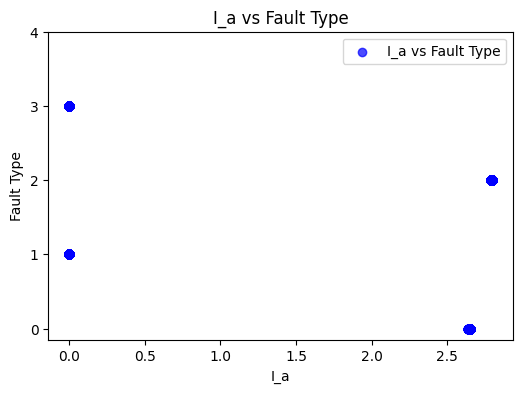

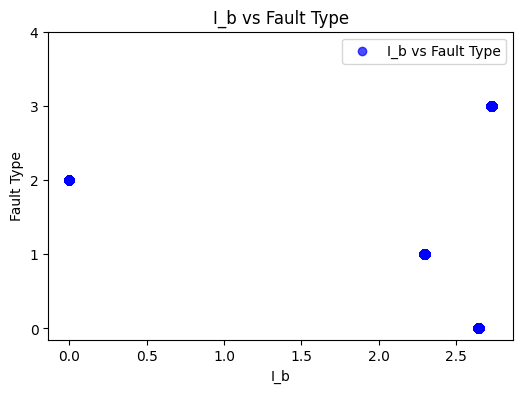

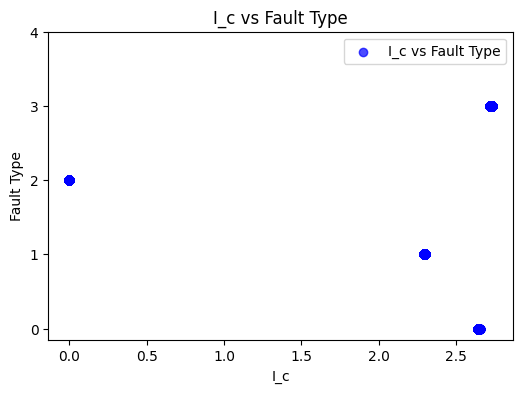

2400
800
9600
3200


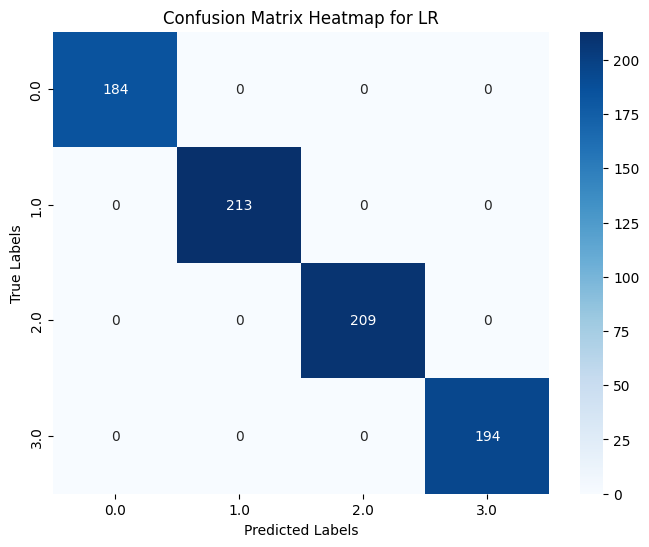

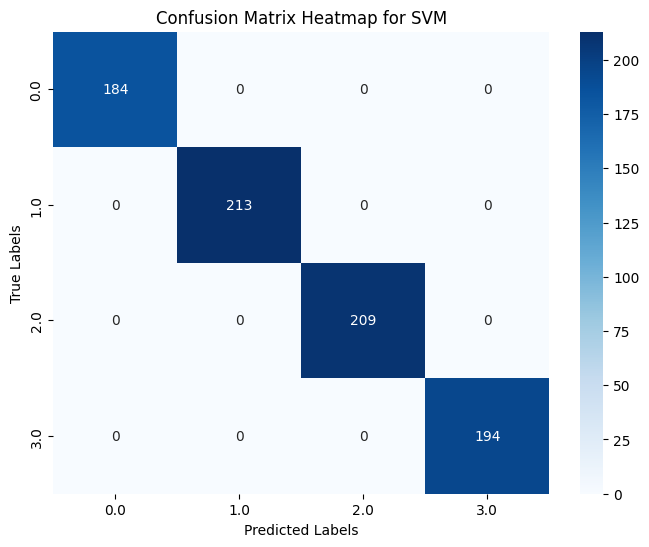

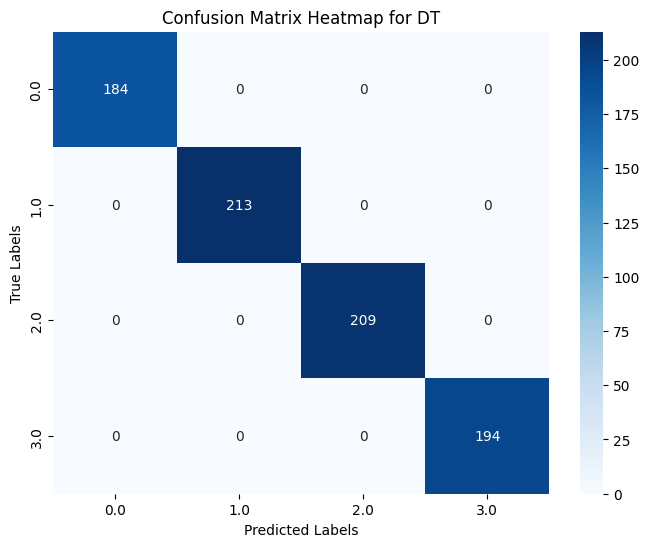

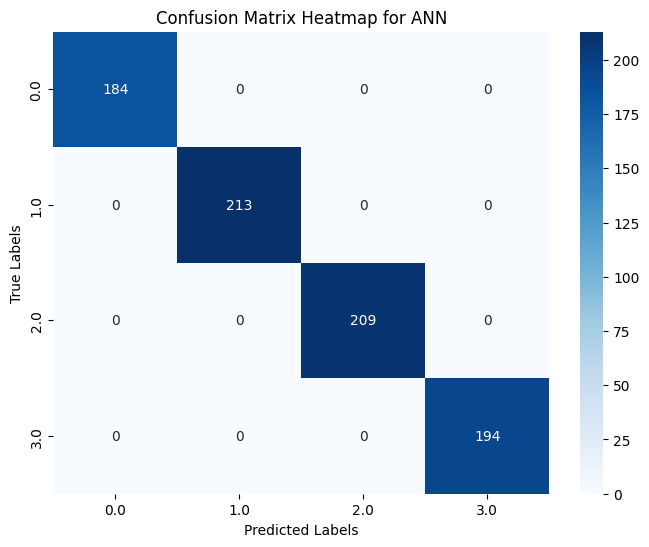

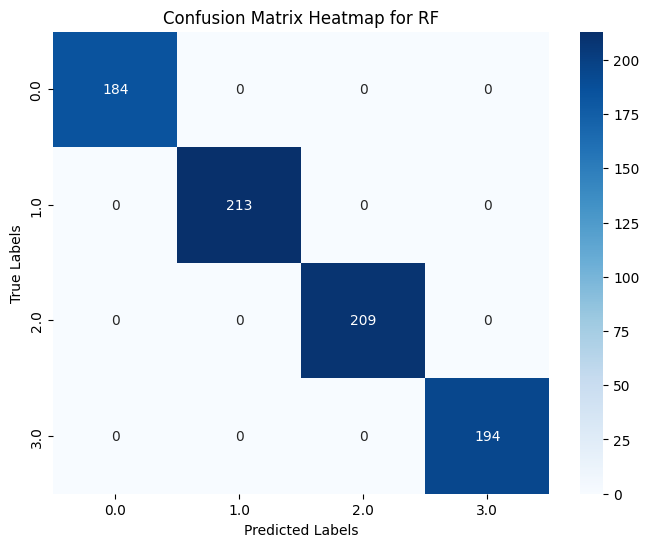

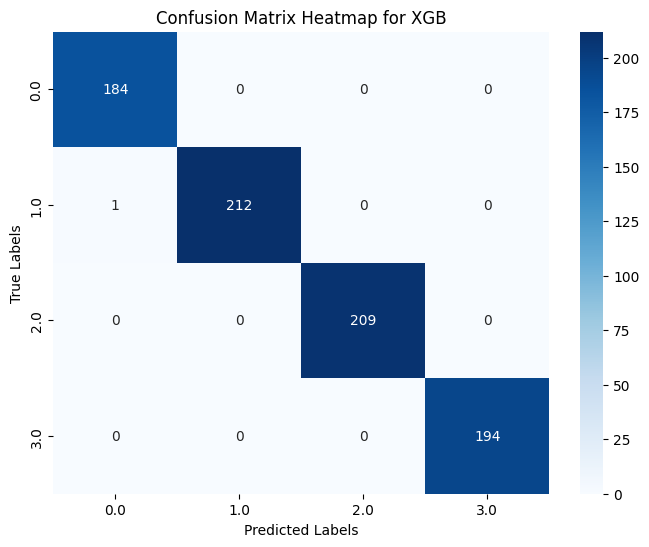

In [9]:
X,y = read_data()
visualize_data(X,y)
X_train, X_test, y_train, y_test = split_data(X,y,0.2)
X_train_scaled,X_test_scaled = normalize_inputs(X_train,X_test)
results_list = []

for model_name, model in models.items():
    result = ML_classifier(model, X_train_scaled, y_train, X_test_scaled, y_test, model_name)
    results_list.append(result)

summary_df = pd.DataFrame(results_list)
summary_df.to_csv("summary.csv")

#Takes long time for hyperparameter Tuning
#hyperparameter_tuning(X_train_scaled,X_test_scaled, y_train,y_test)

